In [46]:
import pandas as pd
import math 
import numpy as np
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
from statsmodels.tsa.holtwinters import ExponentialSmoothing

### Load & Pre-process data

In [47]:
product_df = pd.read_csv('Product Demand.csv')
product_df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0965,St john's,Category_006,2014-01-08,2.0
1,Product_1724,St john's,Category_003,2014-05-31,108.0
2,Product_1521,Surrey,Category_019,2014-06-24,85000.0
3,Product_1521,Surrey,Category_019,2014-06-24,7000.0
4,Product_1507,Oshawa,Category_019,2014-09-02,1250.0


In [39]:
product_df.shape

(1048575, 5)

In [22]:
product_df.dtypes

Product_Code         object
Warehouse            object
Product_Category     object
Date                 object
Order_Demand        float64
dtype: object

In [23]:
product_df.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [40]:
product_df['Order_Demand'].describe()

count    1.048575e+06
mean     4.406817e+03
std      2.969035e+04
min     -1.631813e+05
25%      2.000000e+01
50%      3.000000e+02
75%      2.000000e+03
max      4.000000e+06
Name: Order_Demand, dtype: float64

In [48]:
#replace Order_Demand <0 to 0
product_df['Order_Demand'] = product_df['Order_Demand'].clip(lower=0)


In [49]:
# Checking the number of null values in the 'Date' column before cleaning
num_null_dates = product_df['Date'].isnull().sum()

num_null_dates


11239

In [50]:
# Fill missing values in 'Date' using forward fill method
product_df['Date'] = product_df['Date'].fillna(method='ffill')

# Checking the number of null values in the 'Date' column after cleaning
num_null_dates = product_df['Date'].isnull().sum()

num_null_dates

0

In [82]:


#replace correct date of 2015-02-29 and 2019-02-29
product_df['Date'] = product_df['Date'].replace('2015-02-29','2015-02-28')
product_df['Date'] = product_df['Date'].replace('2019-02-29','2019-02-28')

#convert to date time
product_df['Date'] = pd.to_datetime(product_df['Date'], errors='coerce')
product_df['Year'] = product_df['Date'].dt.year
product_df['Month'] = product_df['Date'].dt.to_period('M')

product_df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month
0,Product_0965,St john's,Category_006,2014-01-08,2.0,2014,2014-01
1,Product_1724,St john's,Category_003,2014-05-31,108.0,2014,2014-05
2,Product_1521,Surrey,Category_019,2014-06-24,85000.0,2014,2014-06
3,Product_1521,Surrey,Category_019,2014-06-24,7000.0,2014,2014-06
4,Product_1507,Oshawa,Category_019,2014-09-02,1250.0,2014,2014-09


In [59]:

# Group by 'Warehouse' and 'Year', then sum up 'Order_Demand'
warehouse_yearly_demand = product_df.groupby(['Warehouse', 'Year'])['Order_Demand'].sum().unstack()
warehouse_yearly_demand

Year,2014,2015,2016,2017,2018,2019
Warehouse,,,,,,
Brampton,198547.0,616560452.0,664781670.0,696390139.0,699932604.0,6.625109e+08
Oshawa,3031847.0,95823181.0,110035879.0,119618414.0,125189016.0,1.236856e+08
St john's,230881.0,29048000.0,28696890.0,40666770.0,30167990.0,2.951953e+07
Surrey,4902619.0,207828361.0,210573486.0,225957413.0,244108811.0,1.407898e+08


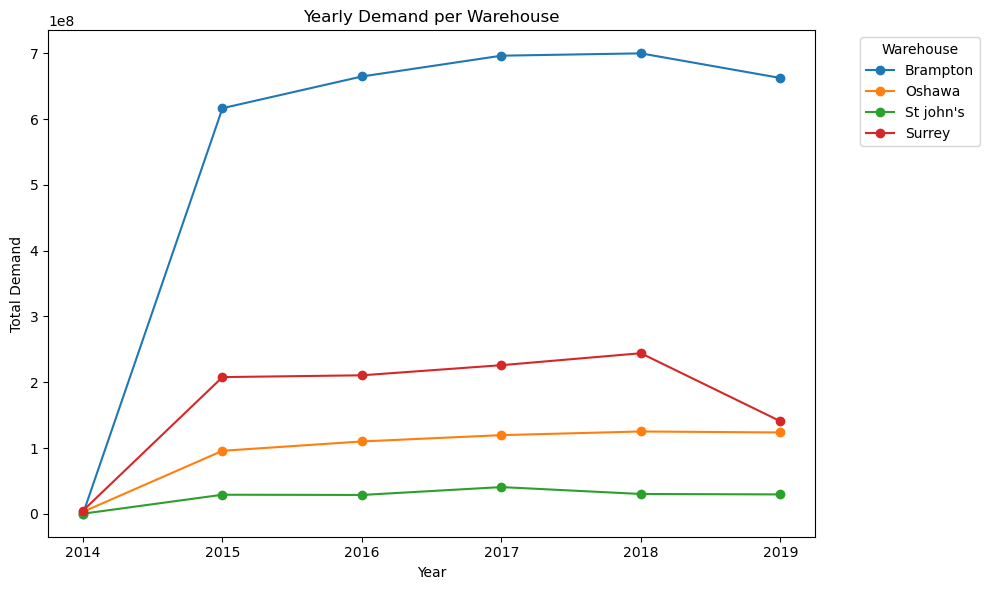

In [60]:
import matplotlib.pyplot as plt

# Transpose the DataFrame for easier plotting (years as rows, warehouses as columns)
warehouse_yearly_demand_transposed = warehouse_yearly_demand.T

# Plotting
plt.figure(figsize=(10, 6))
for warehouse in warehouse_yearly_demand_transposed.columns:
    plt.plot(warehouse_yearly_demand_transposed.index, warehouse_yearly_demand_transposed[warehouse], marker='o', label=warehouse)

plt.title('Yearly Demand per Warehouse')
plt.xlabel('Year')
plt.ylabel('Total Demand')
plt.legend(title='Warehouse', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [62]:
# Counting the number of unique product categories in each warehouse
categories_per_warehouse = product_df_sorted.groupby('Warehouse')['Product_Category'].nunique().reset_index()

categories_per_warehouse

,Warehouse,Product_Category
0,Brampton,25
1,Oshawa,16
2,St john's,25
3,Surrey,28


In [64]:
# Filter the dataset for the Brampton warehouse
brampton_data = product_df_sorted[product_df_sorted['Warehouse'] == 'Brampton']

# Group by Product Category and Year, then sum up Order Demand for each group
brampton_demand_by_category_year = brampton_data.groupby(['Product_Category', 'Year'])['Order_Demand'].sum().unstack(fill_value=0)

brampton_demand_by_category_year


Year,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
Product_Category,,,,,,
Category_001,766.0,252589.0,290215.0,341299.0,352950.0,371915.0
Category_003,0.0,4349.0,10054.0,5636.0,7667.0,11441.0
Category_005,4950.0,23733445.0,23205805.0,27107945.0,28417820.0,25437495.0
Category_006,146505.0,52459666.0,65513768.0,62065232.0,70833201.0,65820102.0
Category_007,11762.0,21559369.0,24739464.0,23488943.0,21831002.0,20129863.0
Category_008,0.0,3657.0,2440.0,3206.0,3791.0,1871.0
Category_009,2.0,59337.0,72572.0,89421.0,126090.0,94574.0
Category_010,0.0,261.0,76.0,1037.0,714.0,2276.0
Category_011,40.0,264092.0,292866.0,380829.0,377797.0,589432.0


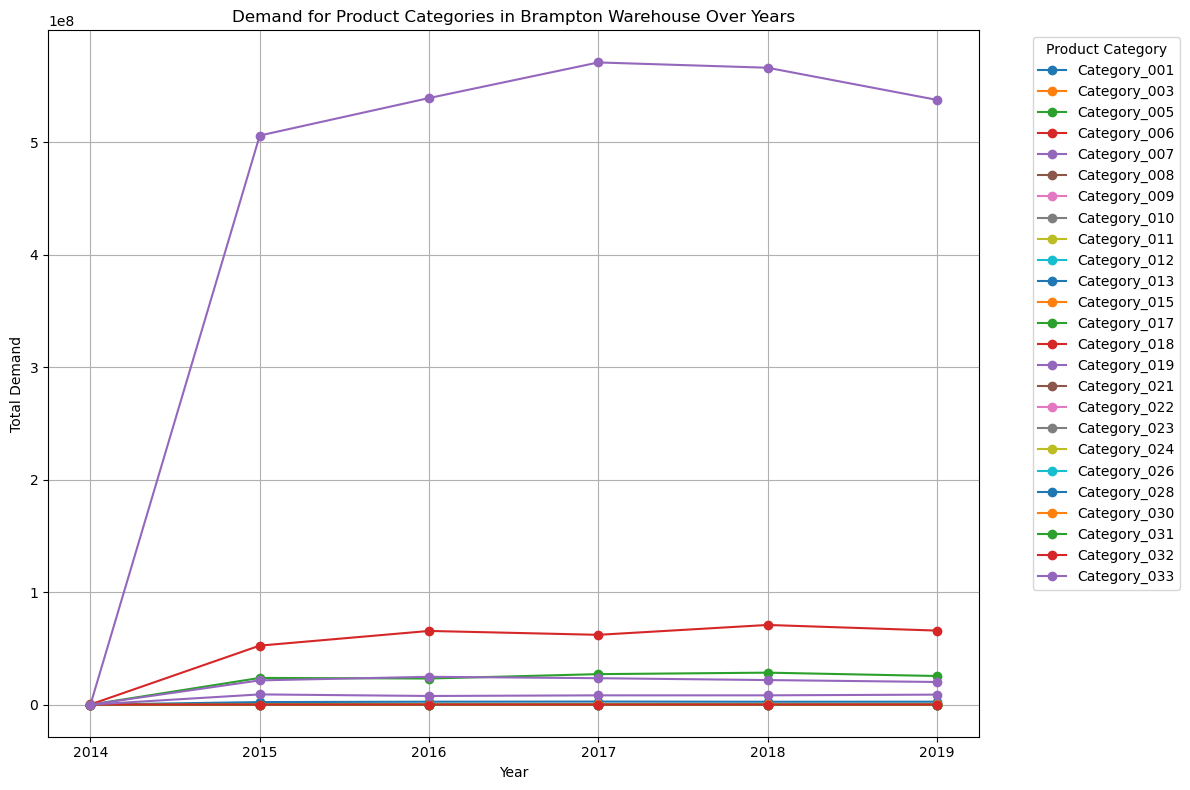

In [65]:
import matplotlib.pyplot as plt

# Transposing the DataFrame so that years are rows and categories are columns
data_for_plotting = brampton_demand_by_category_year.T

# Creating the plot
plt.figure(figsize=(12, 8))
for category in data_for_plotting.columns:
    plt.plot(data_for_plotting.index, data_for_plotting[category], marker='o', label=category)

plt.title('Demand for Product Categories in Brampton Warehouse Over Years')
plt.xlabel('Year')
plt.ylabel('Total Demand')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


### Top 5 product of 2014 & their demand over years

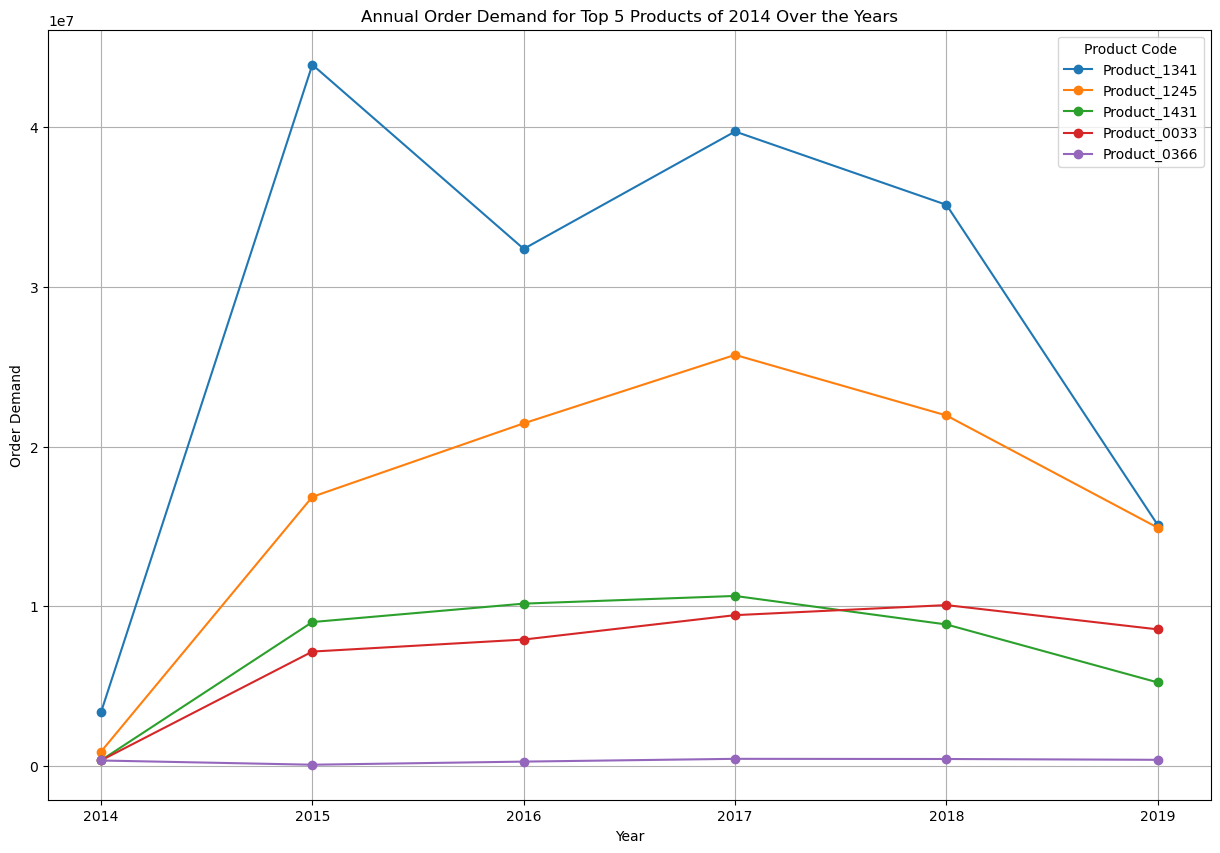

In [66]:
# Filter data for 2014 and identify top 5 products based on demand
data_2014 = product_df[product_df['Year'] == 2014]
top_products_2014 = data_2014.groupby('Product_Code')['Order_Demand'].sum().nlargest(5).index

# Filter the dataset to include only the top 5 products from 2014
top_products_data = product_df[product_df['Product_Code'].isin(top_products_2014)]

# Aggregate demand by product and year
annual_demand_top_products = top_products_data.groupby(['Product_Code', 'Year'])['Order_Demand'].sum().reset_index()

# Plotting
plt.figure(figsize=(15, 10))

for product in top_products_2014:
    product_data = annual_demand_top_products[annual_demand_top_products['Product_Code'] == product]
    plt.plot(product_data['Year'], product_data['Order_Demand'], marker='o', label=product)

plt.title('Annual Order Demand for Top 5 Products of 2014 Over the Years')
plt.xlabel('Year')
plt.ylabel('Order Demand')
plt.legend(title='Product Code')
plt.grid(True)
plt.savefig('Annual Order Demand for Top 5 Products of 2014 Over the Years.png')
plt.show()

In [67]:
# Filter the DataFrame to include only the top products of 2014
top2014_df = data_2014[data_2014['Product_Code'].isin(top_products_2014)]

# Create a pivot table to sum 'Order_Demand' for these top products
top2014 = top2014_df.pivot_table(values='Order_Demand', index='Product_Code', aggfunc='sum')
top2014 = top2014.sort_values(by='Order_Demand', ascending=True)

print(top2014)

              Order_Demand
Product_Code              
Product_0366      349500.0
Product_0033      355000.0
Product_1431      360000.0
Product_1245      900000.0
Product_1341     3366000.0


In [69]:
import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots

In [93]:

# Filter for 2019 data
data_2019 = product_df[product_df['Year'] == 2019]

# Find the category with the highest demand in 2019
top_category_2019 = data_2019.groupby('Product_Category')['Order_Demand'].sum().idxmax()

# Find the top product within this category in 2019
top_product_2019 = data_2019[data_2019['Product_Category'] == top_category_2019].groupby('Product_Code')['Order_Demand'].sum().idxmax()

print("Top category 2019: ", top_category_2019)
print("Top product 2019: ",top_product_2019)


Top category 2019:  Category_019
Top product 2019:  Product_1359


In [76]:
#New dataframe for top product in 2019
top_product_df = product_df[product_df['Product_Code'] == top_product_2019]
top_product_df.head()



,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month
1078,Product_1359,Brampton,Category_019,2015-01-05,2000.0,2015,2015-01
1091,Product_1359,Brampton,Category_019,2015-01-05,25000.0,2015,2015-01
1102,Product_1359,Brampton,Category_019,2015-01-05,100000.0,2015,2015-01
1140,Product_1359,Brampton,Category_019,2015-01-05,300000.0,2015,2015-01
1179,Product_1359,Brampton,Category_019,2015-01-05,150000.0,2015,2015-01


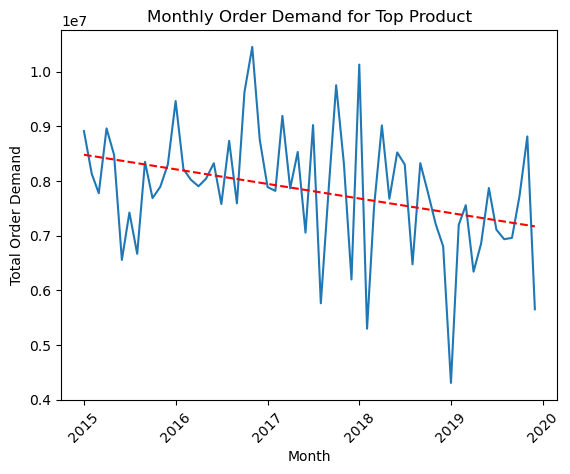

In [109]:

import matplotlib.dates as mdates

# First, convert 'Month' to datetime format
top_product_df['Month'] = pd.to_datetime(top_product_df['Month'])

# Then, aggregate the order demand by month
monthly_demand = top_product_df.groupby(top_product_df['Month'])['Order_Demand'].sum()

# Now, plot the aggregated data

plt.plot(monthly_demand.index, monthly_demand.values)  # Create a line plot

# Fit a simple linear trend line
z = np.polyfit(mdates.date2num(monthly_demand.index), monthly_demand.values, 1)
p = np.poly1d(z)

# Add the trend line to the plot
plt.plot(monthly_demand.index, p(mdates.date2num(monthly_demand.index)), "r--", label='Trend Line')

# Rotating the date labels for better readability
plt.xticks(rotation=45)

# Adding labels and title for clarity
plt.xlabel('Month')
plt.ylabel('Total Order Demand')
plt.title('Monthly Order Demand for Top Product')

# Finally, show the plot
plt.show()



### Forecast the demand of the item of highest demand category in 2019 by Exponential Smoothing

C:\Users\user\AppData\Local\Temp\ipykernel_28908\54774914.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_data = top_product_df.resample('M').sum()
C:\Users\user\anaconda31\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


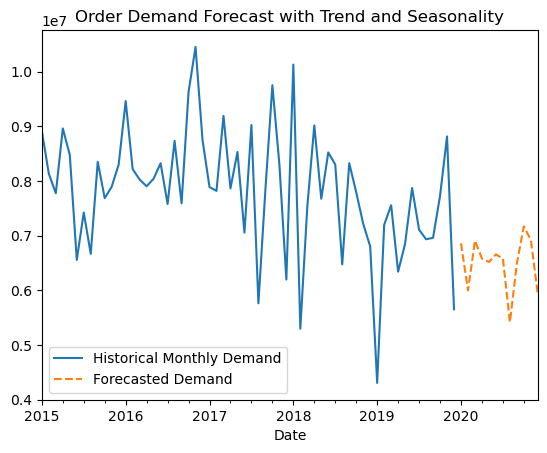

In [110]:
#Convert to date time
top_product_df['Date'] = pd.to_datetime(top_product_df['Date'])
top_product_df.set_index('Date', inplace=True)

# Aggregate order demand by month for this example (ensure the frequency fits your data)
monthly_data = top_product_df.resample('M').sum()

# Fit the Holt-Winters model
model = ExponentialSmoothing(monthly_data['Order_Demand'],trend='additive',seasonal='additive',seasonal_periods=12)
model_fit = model.fit()

# Forecast the next year
forecast_periods = 12
forecast = model_fit.forecast(forecast_periods)

# Plot the results
monthly_data['Order_Demand'].plot(label='Historical Monthly Demand')
forecast.plot(label='Forecasted Demand', linestyle='--')

plt.legend()
plt.title('Order Demand Forecast with Trend and Seasonality')
plt.show()
